In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from patsy import dmatrices
from pandas import Series
from matplotlib import pyplot
from datetime import datetime
from matplotlib.pyplot import figure

import statsmodels.api as sm

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import sys
import warnings
import itertools
warnings.filterwarnings("ignore")


import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA

<Figure size 1280x960 with 0 Axes>

In [2]:
airpax_data = pd.read_csv("C:\\Users\\sumit\\Desktop\\Time Series Forecasting\\AirPassengers.csv")
airpax_data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
#Parse strings to datetime type
airpax_data['Month'] = pd.to_datetime(airpax_data['Month'],infer_datetime_format=True) #convert from string to datetime
airpax_data = airpax_data.set_index(['Month'])

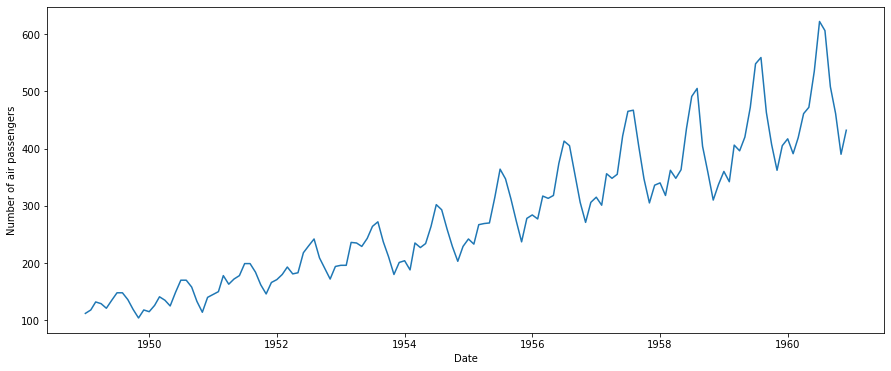

In [4]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(airpax_data)

In [5]:
#Test whether Timeseries is Stationary or not
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

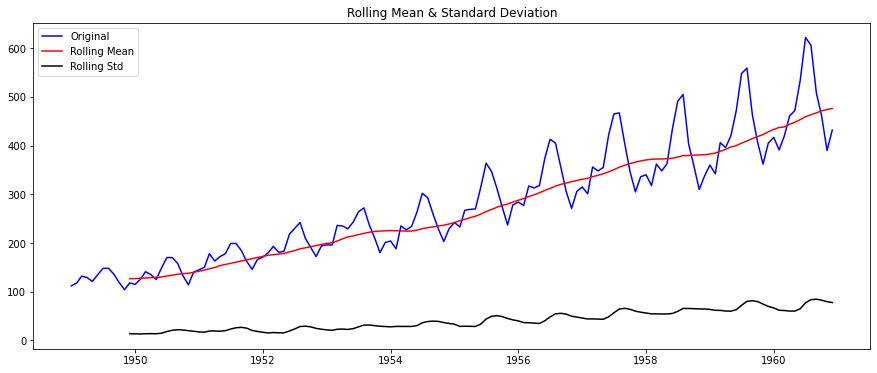

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
test_stationarity(airpax_data)

1) From the above graph, we see that rolling mean has a trend component and rolling standard deviation is fairly constant with time.

2) Critical values are no where close to the Test Statistics. Hence, we can say that our Time Series at the moment is not stationary

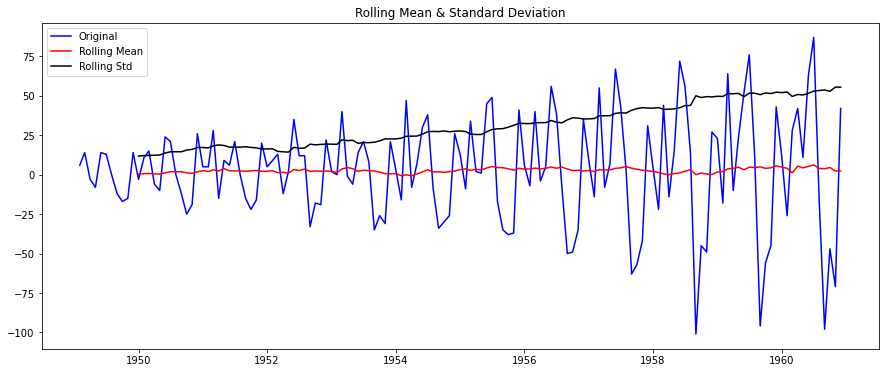

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
airpax_df1 = airpax_data.diff(periods=1)
airpax_df1.dropna(inplace=True)
test_stationarity(airpax_df1)

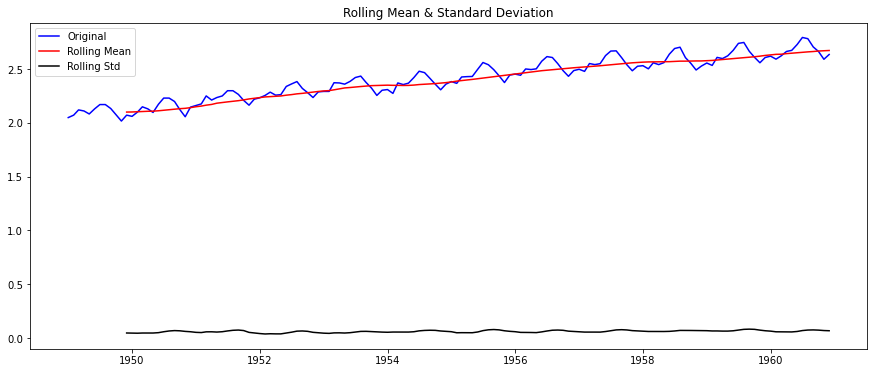

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
airpax_log = np.log10(airpax_data)
airpax_log.dropna(inplace=True)
test_stationarity(airpax_log)

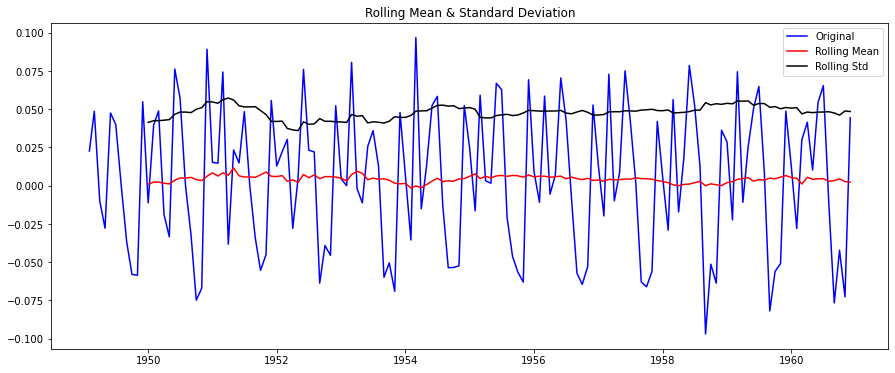

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [9]:
airpax_log_df = airpax_log.diff(periods=1)
airpax_log_df.dropna(inplace=True)
test_stationarity(airpax_log_df)

1) The rolling values appear to be varying slightly but there is no specific trend.
2) The test statistic is smaller than the 10% critical values so we can say with 95% confidence that this is a stationary series.

# Time Series Decomposition

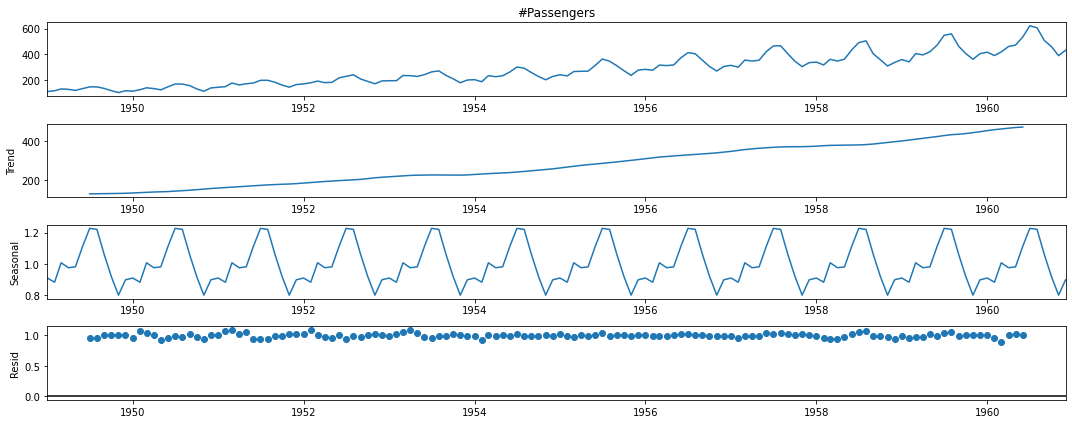

In [10]:
airpax_decompose = sm.tsa.seasonal_decompose(airpax_data['#Passengers'], model="multiplicative", freq=12)
airpax_decompose.plot()
plt.show()

In [11]:
trend = airpax_decompose.trend
seasonal = airpax_decompose.seasonal
residual = airpax_decompose.resid

In [12]:
print("Trend \n",trend.head(24))
print("Seasonal \n",seasonal.head(24))
print("Residual \n",residual.head(24))

Trend 
 Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
1949-12-01    129.750000
1950-01-01    131.250000
1950-02-01    133.083333
1950-03-01    134.916667
1950-04-01    136.416667
1950-05-01    137.416667
1950-06-01    138.750000
1950-07-01    140.916667
1950-08-01    143.166667
1950-09-01    145.708333
1950-10-01    148.416667
1950-11-01    151.541667
1950-12-01    154.708333
Name: trend, dtype: float64
Seasonal 
 Month
1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
1949-06-01    1.112776
1949-07-01    1.226556
1949-08-01    1.219911
1949-09-01    1.060492
1949-10-01    0.921757
1949-11-01    0.801178
1949-12-01    0.898824
1950-01-01    0.910230
1950-02-01    0.883625
1950-03-01    1.007

# Double Exponential (Holt)

In [13]:
train=airpax_data[0:int(len(airpax_data)*0.80)] 
test=airpax_data[int(len(airpax_data)*0.80):]
#Split the data for 21 month test

train_log = np.log10(train['#Passengers'])

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
model_airpax = ExponentialSmoothing(np.asarray(train['#Passengers']),seasonal_periods=24, trend='add',seasonal='mul').fit(optimized=True)

In [16]:
airpax_Holt = test.copy()

In [17]:
airpax_Holt['Holt']=model_airpax.forecast(len(test['#Passengers']))

In [18]:
mean_absolute_percentage_error(test['#Passengers'],airpax_Holt['Holt'])

5.146672695169807

In [19]:
model_airpax.params

{'smoothing_level': 0.8460741334569242,
 'smoothing_trend': 1.2877485756205422e-10,
 'smoothing_seasonal': 8.454549622867379e-12,
 'damping_trend': nan,
 'initial_level': 133.17363323225325,
 'initial_trend': 2.5377193122541852,
 'initial_seasons': array([0.83216032, 0.80488883, 0.93526605, 0.90874462, 0.90506334,
        1.02330665, 1.13041211, 1.11309383, 0.97308952, 0.84018248,
        0.72638814, 0.81172732, 0.81641458, 0.78045026, 0.88666156,
        0.84971341, 0.86153754, 1.00753557, 1.11610175, 1.09296743,
        0.95300649, 0.82469713, 0.72295625, 0.81366005]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

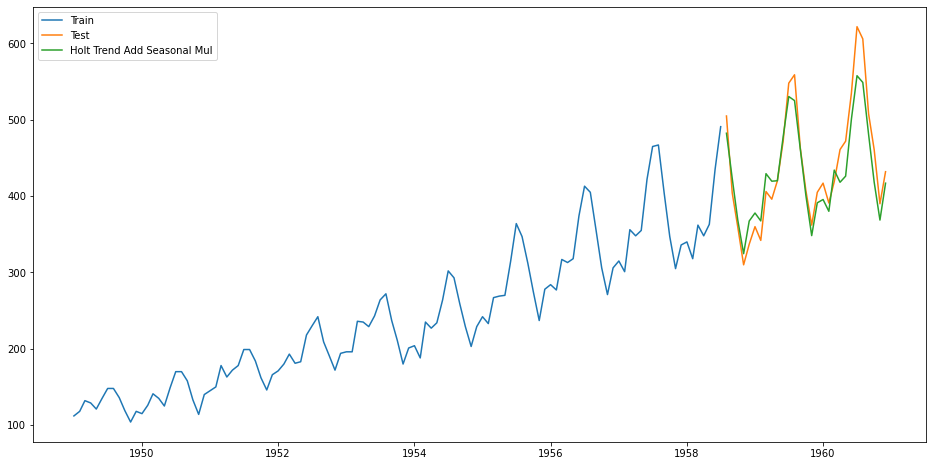

In [20]:
airpax_Holt['Pax'] = model_airpax.forecast(len(test['#Passengers']))
plt.figure(figsize=(16,8))
plt.plot(train['#Passengers'], label='Train')
plt.plot(test['#Passengers'], label='Test')
plt.plot(airpax_Holt['Holt'], label='Holt Trend Add Seasonal Mul')
plt.legend(loc=0)

# Plotting Autocorrelation & Partial Autocorrelation

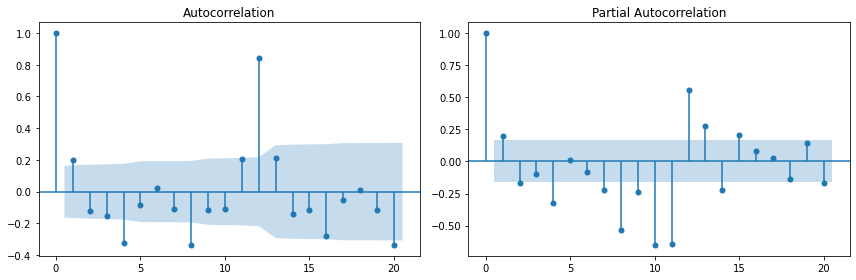

In [21]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(airpax_log_df, lags=20, ax=axes[0])
smt.graphics.plot_pacf(airpax_log_df, lags=20, ax=axes[1])
plt.tight_layout()

# Building Models

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [46]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(train['#Passengers'])

In [24]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 model - AIC:-579.2638924545461


In [25]:
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(0,1,1),
                                seasonal_order=(1,0,1,12),
                                enforce_stationarity=True)

best_results = mod.fit()

print(best_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2743      0.083     -3.311      0.001      -0.437      -0.112
ar.S.L12       0.9958      0.004    247.092      0.000       0.988       1.004
ma.S.L12      -0.6607      0.099     -6.669      0.000      -0.855      -0.467
sigma2         0.0002   3.04e-05      8.079      0.000       0.000       0.000


In [26]:
best_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.2743,0.083,-3.311,0.001,-0.437,-0.112
ar.S.L12,0.9958,0.004,247.092,0.000,0.988,1.004
ma.S.L12,-0.6607,0.099,-6.669,0.000,-0.855,-0.467
sigma2,0.0002,3.04e-05,8.079,0.000,0.000,0.000


In [27]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

In [28]:
pred_dynamic_ci = pred_dynamic.conf_int()

In [29]:
pred99 = best_results.get_forecast(steps=24, alpha=0.1)

In [30]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['Passengers_Forecast'] = np.power(10, pred99.predicted_mean)

In [58]:
# Compute the root mean square error
mse = ((testCopy['#Passengers'] - testCopy['Passengers_Forecast']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 16.645


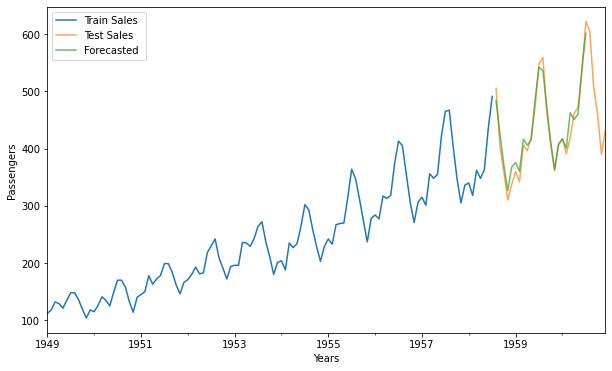

In [38]:
axis = train['#Passengers'].plot(label='Train Sales', figsize=(10, 6))
testCopy['#Passengers'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['Passengers_Forecast'].plot(ax=axis, label='Forecasted ', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Passengers')
plt.legend(loc='best')
plt.show()
plt.close()

# Forecast sales using the best fit ARIMA model

In [39]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [40]:
n_steps = 36
idx = pd.date_range(airpax_data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1960-12-01,483.199769,450.188645,518.631511,450.188645,518.631511
1961-01-01,425.583262,389.953332,464.468688,389.953332,464.468688
1961-02-01,370.920951,335.153911,410.504988,335.153911,410.504988
1961-03-01,326.351724,291.288508,365.635597,291.288508,365.635597
1961-04-01,367.467946,324.378821,416.280850,324.378821,416.280850


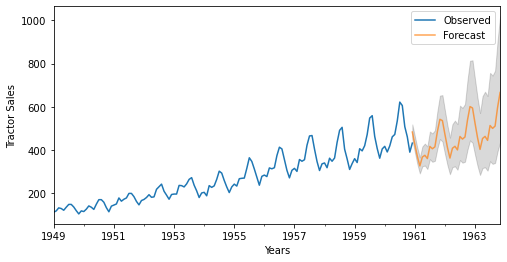

In [41]:
# plot the forecast along with the confidence band
axis = airpax_data['#Passengers'].plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

# Plot ACF and PACF for residuals of ARIMA mode

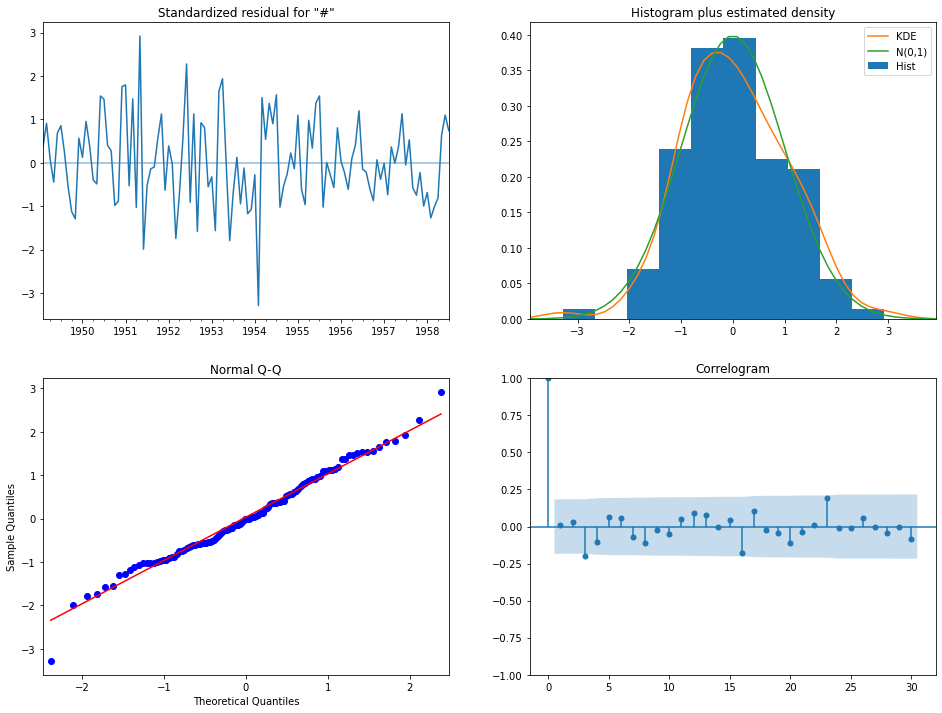

In [42]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()